# Shazam

Have you ever wondered what is happening under the hood of the popular music search tool? How can a track be indentified among the millions of other tracks by a short sample in just a few seconds? Obviously, this is not a mere brute force. Today we will remove the veil and find out what kind of magic happens there by implementing the algorithm on our own.

Refer to the [original article](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf) for implementation details.

## Installing needed libraries

In [1]:
# please read https://github.com/librosa/librosa
# you may need ffmpeg to be installed
!pip install librosa --user

In [0]:
# !conda install -c conda-forge ffmpeg

## Reading and resampling audio tracks database

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# https://nbviewer.jupyter.org/github/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

audios = ['/content/drive/My Drive/InformationRetrieval2020/Shazam/mp3/ACDC.mp3', '/content/drive/My Drive/InformationRetrieval2020/Shazam/mp3/iamthemorning.mp3', '/content/drive/My Drive/InformationRetrieval2020/Shazam/mp3/Little Big.mp3']
request_audio = '/content/drive/My Drive/InformationRetrieval2020/Shazam/mp3/request.mp3'

def read_and_resample(path, sample_rate):
    # read and resample to 22KHz
    y, sr = librosa.load(path, sr=sample_rate)    
    print(f"{path} length is {y.shape[0] / sample_rate / 60.:.2f} min")
    return y

dataset = {}
sample_rate = 22050
# reading all audios
for path in audios:
    dataset[path] = read_and_resample(path, sample_rate)

# reading request audio
request_data = read_and_resample(request_audio, sample_rate)

/content/drive/My Drive/InformationRetrieval2020/Shazam/mp3/ACDC.mp3 length is 4.88 min
/content/drive/My Drive/InformationRetrieval2020/Shazam/mp3/iamthemorning.mp3 length is 3.83 min
/content/drive/My Drive/InformationRetrieval2020/Shazam/mp3/Little Big.mp3 length is 2.68 min
/content/drive/My Drive/InformationRetrieval2020/Shazam/mp3/request.mp3 length is 0.17 min


## Visualizing example spectrogram

We will use [Mel scale](https://en.wikipedia.org/wiki/Mel_scale) to emphasize perception rather than amplitude.

Spectrogram shape: (128, 12599)


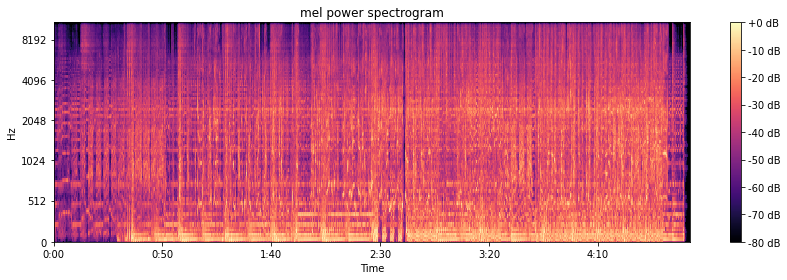

In [5]:
import numpy as np
import matplotlib.pyplot as plt

y = dataset['/content/drive/My Drive/InformationRetrieval2020/Shazam/mp3/ACDC.mp3']

# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sample_rate, n_mels=128)

print(f"Spectrogram shape: {S.shape}")

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

## Forming constellations

Time resolution: 0.02321972427354941
/content/drive/My Drive/InformationRetrieval2020/Shazam/mp3/ACDC.mp3


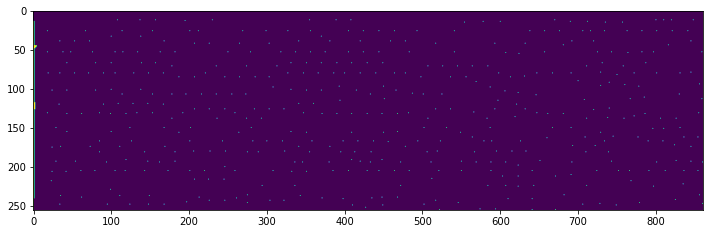

6587
/content/drive/My Drive/InformationRetrieval2020/Shazam/mp3/iamthemorning.mp3


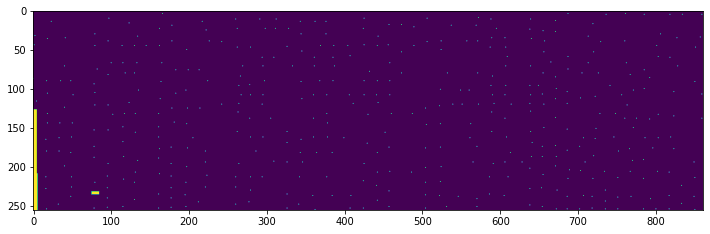

5128
/content/drive/My Drive/InformationRetrieval2020/Shazam/mp3/Little Big.mp3


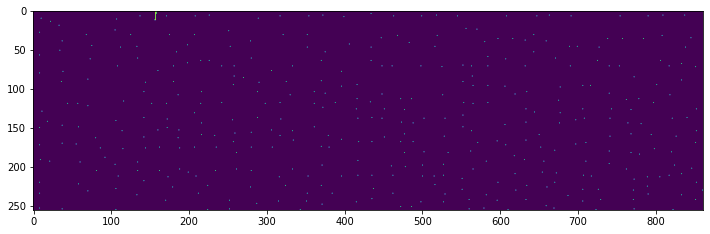

3479
/content/drive/My Drive/InformationRetrieval2020/Shazam/mp3/request.mp3


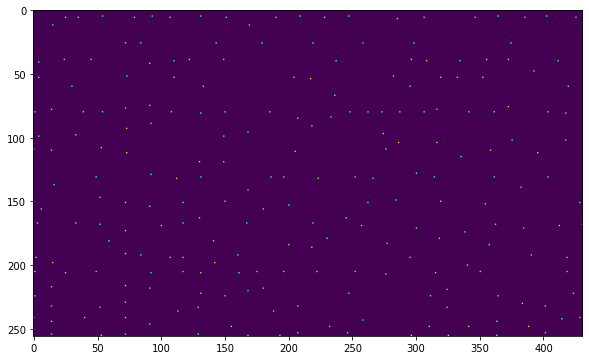

234


In [6]:
from scipy.ndimage.filters import maximum_filter
import scipy.ndimage as ndimage
neighborhood_size = 20

# sec/sample - constant for all files
wav = dataset["/content/drive/My Drive/InformationRetrieval2020/Shazam/mp3/ACDC.mp3"]
time_resolution = (wav.shape[0] / sample_rate) / S.shape[1]
print("Time resolution:", time_resolution)

def form_constellation(name, wav, sample_rate, time_resolution):
    S = librosa.feature.melspectrogram(wav, sr=sample_rate, n_mels=256, fmax=4000)
    S = librosa.power_to_db(S, ref=np.max)
    # get local maxima
    Sb = maximum_filter(S, neighborhood_size) == S
    
    Sbd, num_objects = ndimage.label(Sb)
    objs = ndimage.find_objects(Sbd)
    points = []
    for dy, dx in objs:
        x_center = (dx.start + dx.stop - 1) // 2
        y_center = (dy.start + dy.stop - 1) // 2    
        if (dx.stop - dx.start) * (dy.stop - dy.start) == 1:
            points.append((x_center, y_center))
            
    # 20 seconds
    low = int(0 / time_resolution)
    hi = int(20 / time_resolution)
    print(name)
    plt.figure(figsize=(12,6))
    plt.imshow(Sb[:, low:hi])
    plt.show()
    print(len(points))
    return sorted(points) 
    

constellations = {}
for name, wav in dataset.items():
    constellations[name] = form_constellation(name, wav, sample_rate, time_resolution)

request_constellation = form_constellation(request_audio, request_data, sample_rate, time_resolution)

## Task

### 1. Build index from constellations

In [7]:
print(time_resolution)
target = (int(1 / time_resolution), int(5 / time_resolution), -50, 50)    # start, end, Hz low, Hz high 
index = {}
request = {}

def build_constellation_index(constellation_collection, target):
  """
  each constellation is in format (time, frequency)
  """
  # TODO: build shazam index for a collection of constellations
  # consider some window (target) for every point
  # for every point inside this window make an entry in the index (or update it, if the key exists)
  # keys are triples of the form (f1, f2, dt), values are lists with tuples (t, name)
  result_index = {} 

  def check_in_target(candidate_point):
    c_t, c_f = candidate_point
    t_start, t_end = point[0]+target[0], point[0]+target[1]
    t_low, t_high = point[1]+target[2], point[1]+target[3]

    if c_t>= t_start and c_t <= t_end and c_f>=t_low and c_f<=t_high:
      if (point[1], c_f, c_t-point[0]) not in result_index:
        result_index[ (point[1], c_f, c_t-point[0]) ] = [(point[0], audio_name)]
      else: 
        result_index[ (point[1], c_f, c_t-point[0]) ].append((point[0], audio_name))

  for audio_name, constellation in constellation_collection.items():
    for point in constellation:
      target_zone_hashes = list(map(check_in_target, constellation)) # get points withing target zone # create hashes using point and its target zone
  return result_index

index = build_constellation_index(constellations, target)
request = build_constellation_index({request_audio:request_constellation}, target)

0.02321972427354941


### 2. Compare request track with all audios 

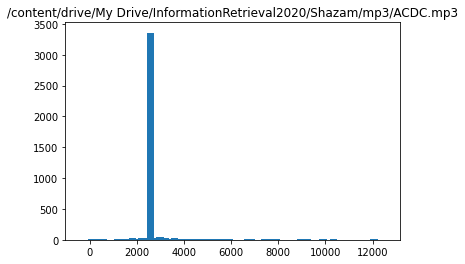

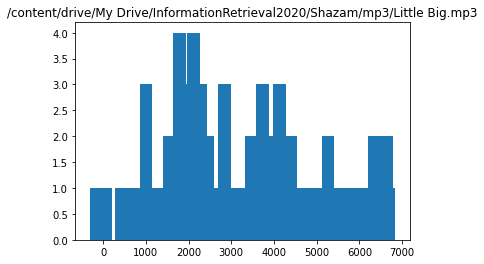

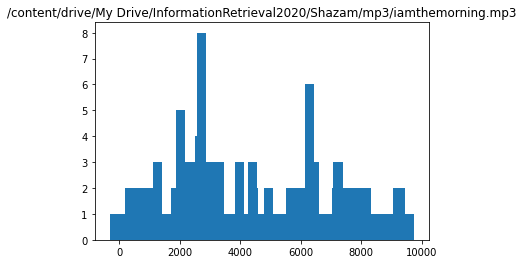

In [8]:
# TODO for every audio find all keys that match request audio keys 
# for every such match calculate time offset (difference between audio and request)
# display counts of matches for every time offset (using histogram, for example)

from collections import Counter
import numpy as np

matching_tracks = {}

for hash_, request_time_name in request.items():
  try: 
    matches = index[hash_]
    for t, name in matches:
      for request_time, _ in request_time_name:
        offset = t-request_time

        if name in matching_tracks:
            matching_tracks[name][offset] +=1
        else: 
          matching_tracks[name] = Counter()
          matching_tracks[name][offset] +=1
  except KeyError:
    pass

# display that stuff as a histogram

def draw_hists(name, values):
  """
  name: string
  values: Counter object
  """
  plt.bar(values.keys(), values.values(), width=300)
  plt.title(name)
  plt.show()

for name, matches in matching_tracks.items():
  draw_hists(name, matches)